In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from IPython.display import display

In [2]:
# 데이터 로드 및 전처리

# 1) CSV 데이터 로드
df = pd.read_csv("exchange_data.csv")

# 2) date 날짜 타입으로 바꾸고 정렬
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# 3) 숫자 컬럼에서 콤마 제거 후 float 변환
numeric_cols = ["Price", "Open", "High", "Low"]

for col in numeric_cols:
  df[col] = df[col].astype(str).str.replace(",", "").astype(float)

print("전처리 후 데이터 상위 5개 테스트 출력:")
display(df.head())

# 4) 다음날 종가 예측을 위한 타깃 생성 (Next_Price)
df["Next_Price"] = df["Price"].shift(-1)

# (내일 - 오늘) 변화량
df["Next_Return"] = df["Next_Price"] - df["Price"]
df = df[:-1].reset_index(drop=True)

print("\nNext_Price 생성 후 상위 5개 테스트 줄력:")
display(df.head())

전처리 후 데이터 상위 5개 테스트 출력:


,Date,Price,Open,High,Low,Vol.,Change
0,2015-11-18,1165.45,1169.67,1175.51,1166.21,NaN,-0.28%
1,2015-11-19,1154.66,1166.39,1167.82,1155.36,NaN,-0.93%
2,2015-11-20,1153.62,1155.86,1160.53,1150.36,NaN,-0.09%
3,2015-11-23,1157.86,1154.61,1161.76,1153.85,NaN,0.37%
4,2015-11-24,1145.72,1158.86,1159.91,1146.45,NaN,-1.05%



Next_Price 생성 후 상위 5개 테스트 줄력:


,Date,Price,Open,High,Low,Vol.,Change,Next_Price,Next_Return
0,2015-11-18,1165.45,1169.67,1175.51,1166.21,NaN,-0.28%,1154.66,-10.79
1,2015-11-19,1154.66,1166.39,1167.82,1155.36,NaN,-0.93%,1153.62,-1.04
2,2015-11-20,1153.62,1155.86,1160.53,1150.36,NaN,-0.09%,1157.86,4.24
3,2015-11-23,1157.86,1154.61,1161.76,1153.85,NaN,0.37%,1145.72,-12.14
4,2015-11-24,1145.72,1158.86,1159.91,1146.45,NaN,-1.05%,1143.21,-2.51


In [3]:
# Feature / Target 설정 + Train/Test Split

# 1) Feature: 해당 날짜의 Price/Open/High/Low
X = df[["Price", "Open", "High", "Low"]]

# 2) Target: 내일 변화량
y = df["Next_Return"]

# 3) 그래프용 날짜 지정
dates = df["Date"].values

# 4) 앞부분 80%를 Train, 나머지 20%를 Test로 사용
train_ratio = 0.8
train_size = int(len(X) * train_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

test_dates = dates[train_size:]

print(f"전체 샘플 데이터 수: {len(X)}")
print(f"Train 샘플 데이터 수: {len(X_train)}")
print(f"Test 샘플 데이터 수: {len(X_test)}")

전체 샘플 데이터 수: 2609
Train 샘플 데이터 수: 2087
Test 샘플 데이터 수: 522


In [4]:
# Gradient Boosting 모델 정의 및 학습

model = GradientBoostingRegressor (
    n_estimators=500,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

model.fit(X_train, y_train)

print("Gradient 모델 학습 complete !")

Gradient 모델 학습 complete !


In [5]:
# 예측 및 Global Test 성능 평가

# 1) 예측 변화량
y_pred_return = model.predict(X_test)

# 2) 예측한 '내일 가격' = 오늘 가격 + 예측 변화량

# test한 시점의 오늘 가격
today_price_test = X_test["Price"].values
y_pred_price = today_price_test + y_pred_return

# 실제 내일 가격 (타깃 복원)
y_test_price = df["Next_Price"].iloc[train_size:].values

# 2) 전체 구간 기준 성능 지표
mae= mean_absolute_error(y_test_price, y_pred_price)
mse_global = mean_squared_error(y_test_price, y_pred_price)
rmse_global = np.sqrt(mse_global)
r2 = r2_score(y_test_price, y_pred_price)

print("Global Test 성능 지표:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse_global:.4f}")
print(f"RMSE: {rmse_global:.4f}")
print(f"R^2: {r2:.4f}")


Global Test 성능 지표:
MAE: 8.1297
MSE: 118.0922
RMSE: 10.8670
R^2: 0.9457


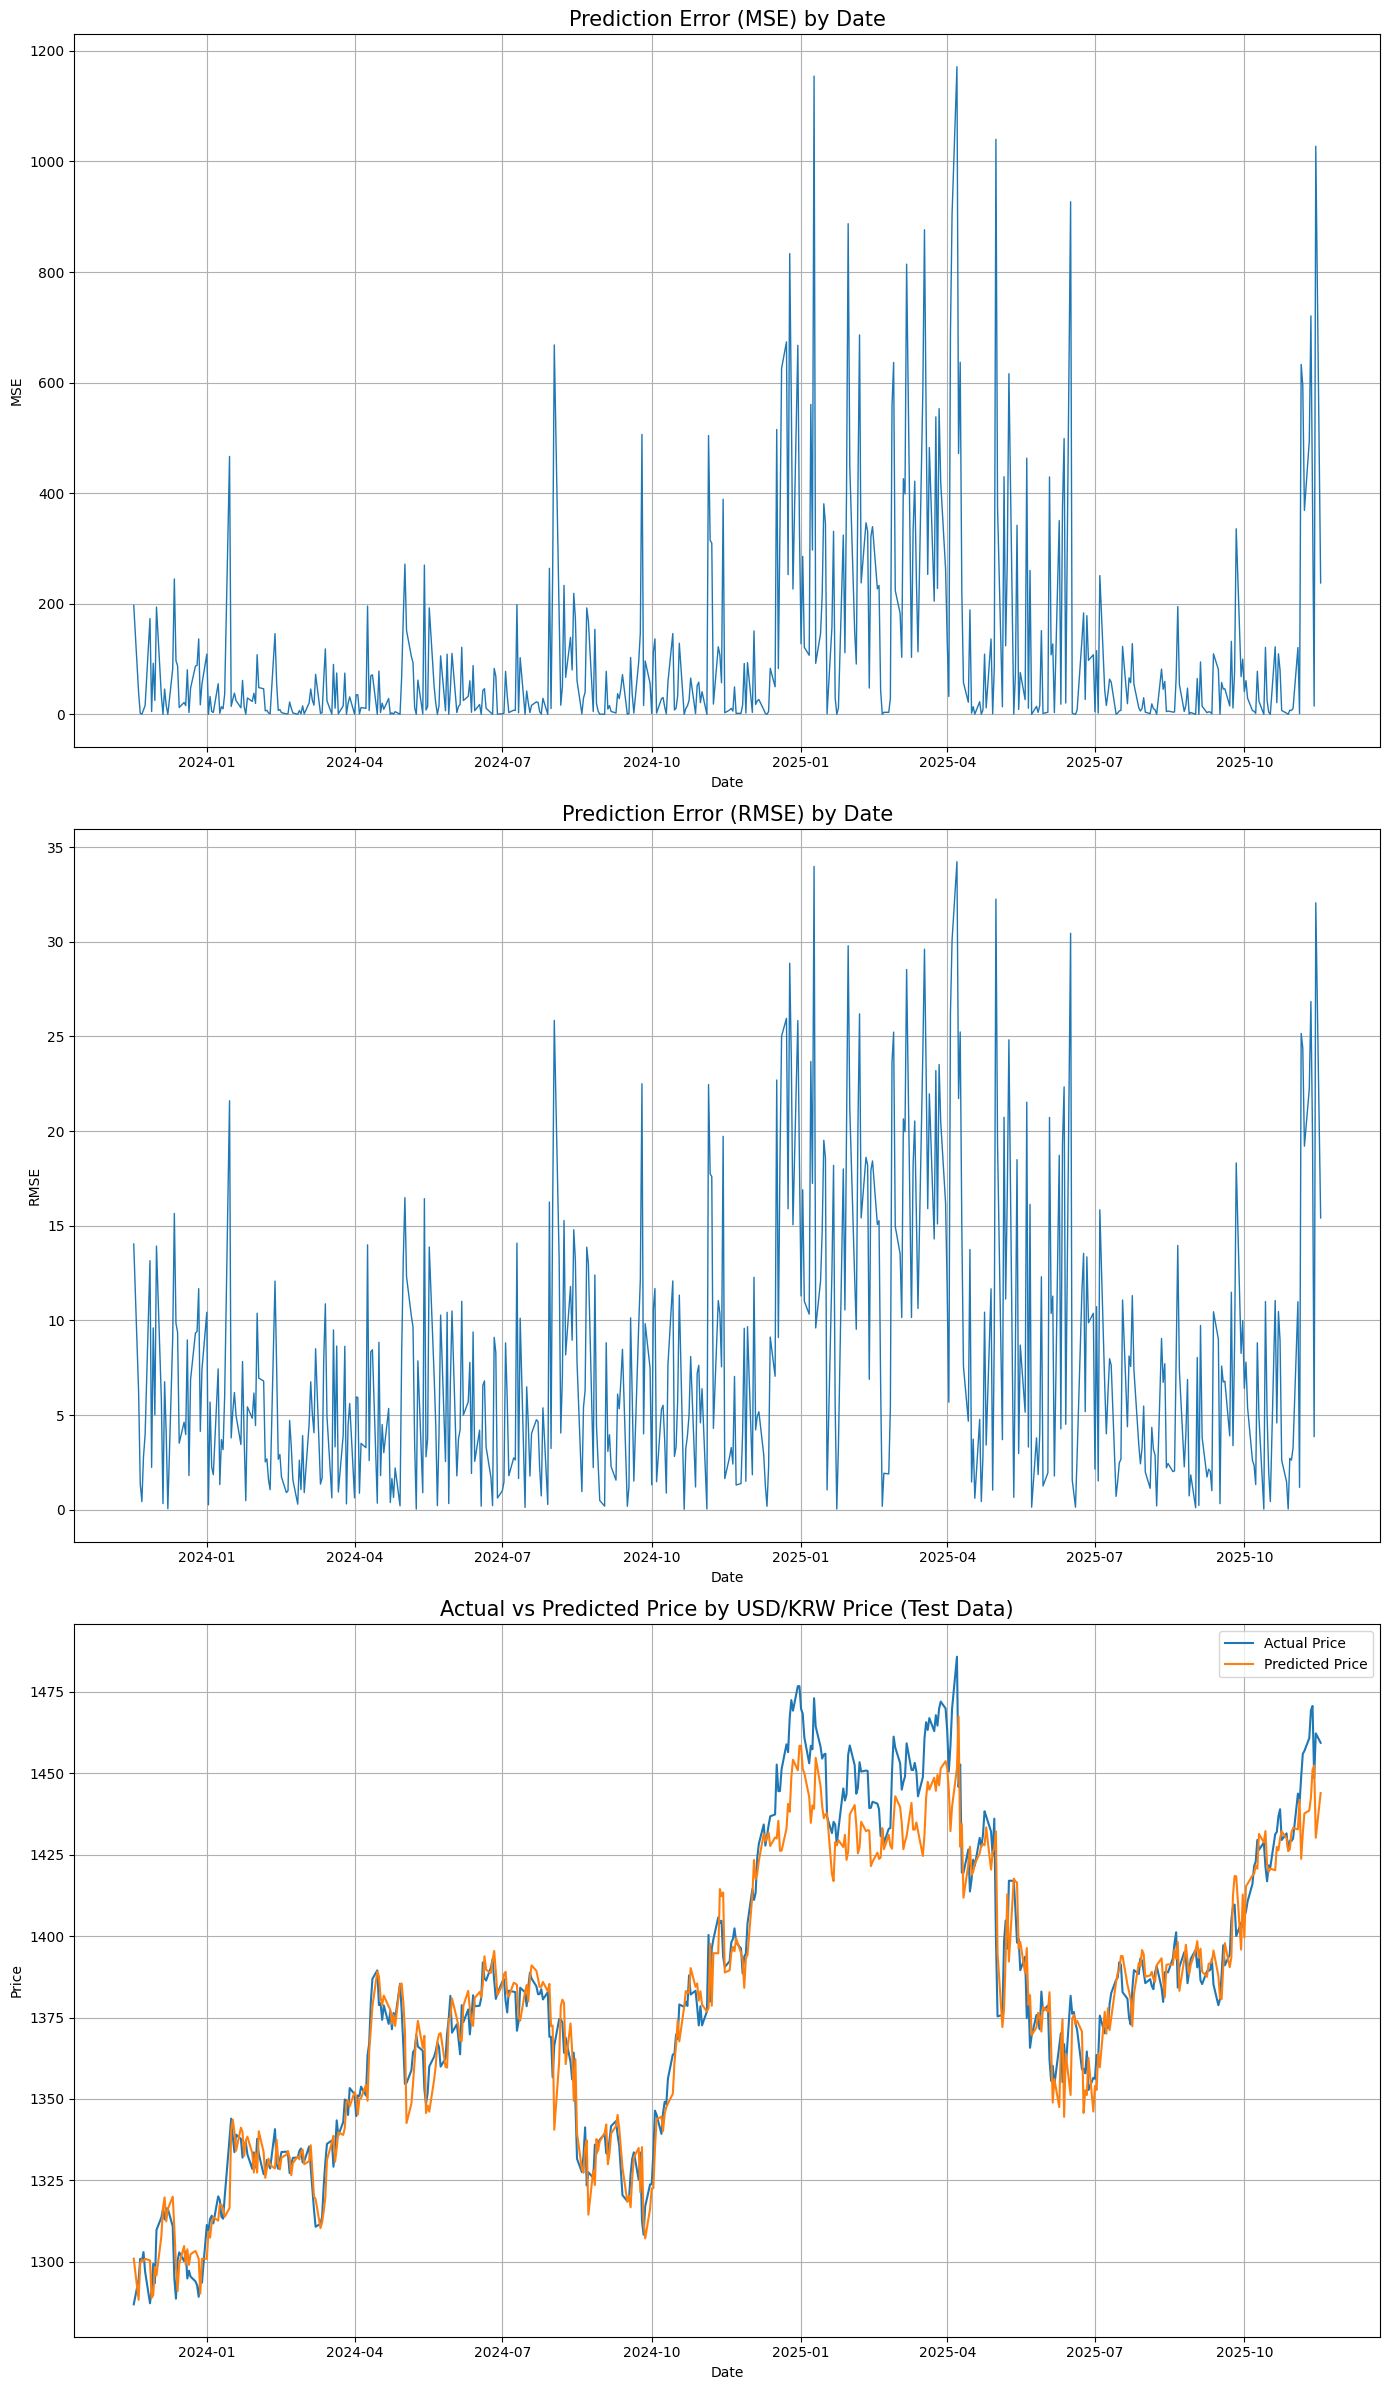

In [ ]:
# 날짜별 에러 및 실제 vs 예측 시각화

# 1) 각 시점별 에러 계산
mse_per_step = (y_test_price - y_pred_price) ** 2
rmse_per_step = np.sqrt(mse_per_step)


# 1-1) MSE / RMSE 요약 통계 출력 - 포스터 기재용 (평가 지표)
print("\n===== MSE / RMSE Summary (Gradient Boosting) =====")

print("▶ MSE")
print(f"  Min  MSE : {mse_per_step.min():.4f}")
print(f"  Max  MSE : {mse_per_step.max():.4f}")
print(f"  Mid  MSE : {np.median(mse_per_step):.4f}")
print(f"  Mean MSE : {mse_per_step.mean():.4f}")

print("\n▶ RMSE")
print(f"  Min  RMSE : {rmse_per_step.min():.4f}")
print(f"  Max  RMSE : {rmse_per_step.max():.4f}")
print(f"  Mid  RMSE : {np.median(rmse_per_step):.4f}")
print(f"  Mean RMSE : {rmse_per_step.mean():.4f}")

# 2) 시각화
plt.figure(figsize=(14,24))

# MSE Plot
plt.subplot(3, 1, 1)
plt.plot(test_dates, mse_per_step, linewidth=1)
plt.title("Prediction Error (MSE) by Date", fontsize=15)
plt.xlabel("Date")
plt.ylabel("MSE")
plt.grid(True)

# RMSE Plot
plt.subplot(3, 1, 2)
plt.plot(test_dates, rmse_per_step, linewidth=1)
plt.title("Prediction Error (RMSE) by Date", fontsize=15)
plt.xlabel("Date")
plt.ylabel("RMSE")
plt.grid(True)

# Actual vs Predicted Plot
plt.subplot(3, 1, 3)
plt.plot(test_dates, y_test_price, label="Actual Price", linewidth=1.5)
plt.plot(test_dates, y_pred_price, label="Predicted Price", linewidth=1.5)
plt.title("Actual vs Predicted Price by USD/KRW Price (Test Data)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()